In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from adjustText import adjust_text
from sklearn.linear_model import LinearRegression

final_results_path = "results/final"

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [70]:
model_order = ["mlp", "cnn", "lstm"]
backend_order = ["jax", "jax-keras", "tf-keras", "torch-keras", "torch"]
precision_order = ["fp32", "fp16", "bf16", "mixed_fp16", "mixed_bf16"]
seed_order = ["42", "43", "44"]

Before all, a dataframe with all experiments' configuration and CSV paths is defined, for easier data manipulation.

In [71]:
# Dictionary to store the data
rows = []
error_rows = []

# Iterate through the seed folders
for seed in os.listdir(final_results_path):
    seed_path = os.path.join(final_results_path, seed)
    
    # Check that it is a directory
    if os.path.isdir(seed_path):

        # Iterate through the model folders inside each seed
        for folder in os.listdir(seed_path):
            folder_path = os.path.join(seed_path, folder)

            if not os.path.isdir(folder_path):
                continue

            # Extract info from folder name
            # Precision can contain _, so a workaround is needed
            timestamp, backend, model_type, model_complexity, right = folder.split("_", 4)
            precision, _ = right.rsplit("_", 1) # precision, seed

            experiment_info = {
                "timestamp": timestamp,
                "backend": backend,
                "model_type": model_type,
                "model_complexity": model_complexity,
                "precision": precision,
                "seed": seed,
            }

            if "error.txt" in os.listdir(folder_path):
                error_rows.append({
                    **experiment_info,
                    "path": os.path.join(folder_path, "error.txt")
                })
                continue

            # Add csv files' info
            for file in os.listdir(folder_path):
                if file.endswith(".csv"):
                    rows.append({
                        **experiment_info,
                        "filename": os.path.splitext(file)[0],  # Name without extension
                        "path": os.path.join(folder_path, file)
                    })


index_df = pd.DataFrame(rows)
error_df = pd.DataFrame(error_rows)

In [72]:
index_df.head()

,timestamp,backend,model_type,model_complexity,precision,seed,filename,path
0,20250724-142036,torch,mlp,simple,fp32,42,train_samples,results/final/42/20250724-142036_torch_mlp_sim...
1,20250724-142036,torch,mlp,simple,fp32,42,test_samples,results/final/42/20250724-142036_torch_mlp_sim...
2,20250724-142036,torch,mlp,simple,fp32,42,global_metrics,results/final/42/20250724-142036_torch_mlp_sim...
3,20250724-142036,torch,mlp,simple,fp32,42,train,results/final/42/20250724-142036_torch_mlp_sim...
4,20250724-142036,torch,mlp,simple,fp32,42,test,results/final/42/20250724-142036_torch_mlp_sim...


In [73]:
error_df.head()

,timestamp,backend,model_type,model_complexity,precision,seed,path
0,20250728-145122,torch-keras,lstm,simple,fp16,42,results/final/42/20250728-145122_torch-keras_l...
1,20250729-134409,jax,lstm,simple,bf16,42,results/final/42/20250729-134409_jax_lstm_simp...
2,20250726-152014,tf-keras,lstm,simple,bf16,42,results/final/42/20250726-152014_tf-keras_lstm...
3,20250728-145247,torch-keras,lstm,simple,bf16,42,results/final/42/20250728-145247_torch-keras_l...
4,20250729-134358,jax,lstm,simple,fp16,42,results/final/42/20250729-134358_jax_lstm_simp...


## Statistical analysis ##

In [74]:
experiment_config = ["backend", "model_type", "model_complexity", "precision", "seed"]
rows = []

for keys, subset_df in index_df.groupby(experiment_config):
    backend, model_type, model_complexity, precision, seed = keys

    row = {
        "backend": backend,
        "model_type": model_type,
        "model_complexity": model_complexity,
        "precision": precision,
        "seed": int(seed),
    }



    # --- Global metrics ---
    global_metrics_row = subset_df[subset_df["filename"] == "global_metrics"]
    global_metrics_df = pd.read_csv(global_metrics_row.iloc[0]["path"])
    global_metrics = global_metrics_df[["training_time", "testing_time"]].iloc[0]
    row.update(global_metrics.to_dict())



    # --- Train ---
    train_row = subset_df[subset_df["filename"] == "train"]
    train_df = pd.read_csv(train_row.iloc[0]["path"])

    # Metric can be accuracy or MAE
    try:
        metric_mean = train_df["accuracy"].mean()
        val_metric_mean = train_df["val_accuracy"].mean()
    except KeyError:
        metric_mean = train_df["mae"].mean()
        val_metric_mean = train_df["val_mae"].mean()

    row.update({
        "train_loss_mean": train_df["loss"].mean(),
        "train_metric_mean": metric_mean,
        "train_val_loss_mean": train_df["val_loss"].mean(),
        "train_val_metric_mean": val_metric_mean,
        "train_epoch_time_mean": train_df["epoch_time"].mean()
    })



    # --- Train samples ---
    train_samples_row = subset_df[subset_df["filename"] == "train_samples"]
    train_samples_df = pd.read_csv(train_samples_row.iloc[0]["path"])
    row.update({
        "train_gpu_utilization_mean": train_samples_df["gpu_2_utilization"].mean(),
        "train_gpu_memory_mean": train_samples_df["gpu_2_memory_used"].mean(),
        "train_gpu_power_mean": train_samples_df["gpu_2_power"].mean(),
    })



    # --- Test ---
    test_row = subset_df[subset_df["filename"] == "test"]
    test_df = pd.read_csv(test_row.iloc[0]["path"])

    try:
        metric_mean = train_df["accuracy"].mean()
    except KeyError:
        metric_mean = train_df["mae"].mean()

    row.update({
        "test_loss_mean": test_df["loss"].mean(),
        "test_metric_mean": metric_mean
    })



    # --- Test samples ---
    test_samples_row = subset_df[subset_df["filename"] == "test_samples"]
    test_samples_df = pd.read_csv(test_samples_row.iloc[0]["path"])
    row.update({
        "test_gpu_utilization_mean": test_samples_df["gpu_2_utilization"].mean(),
        "test_gpu_memory_mean": test_samples_df["gpu_2_memory_used"].mean(),
        "test_gpu_power_mean": test_samples_df["gpu_2_power"].mean(),
    })

    rows.append(row)

metrics_df = pd.DataFrame(rows)

In [75]:
metrics_df.head()

,backend,model_type,model_complexity,precision,seed,training_time,testing_time,train_loss_mean,train_metric_mean,train_val_loss_mean,train_val_metric_mean,train_epoch_time_mean,train_gpu_utilization_mean,train_gpu_memory_mean,train_gpu_power_mean,test_loss_mean,test_metric_mean,test_gpu_utilization_mean,test_gpu_memory_mean,test_gpu_power_mean
0,jax,cnn,simple,bf16,42,276.151817,2.418015,1.786719,0.358793,1.879609,0.401124,2.735608,9.556777,62087.106914,68.989505,1.859375,0.358793,NaN,NaN,NaN
1,jax,cnn,simple,bf16,43,258.165341,2.439186,1.730703,0.381797,1.834219,0.408910,2.553460,11.980392,62087.101225,68.816047,1.812500,0.381797,NaN,NaN,NaN
2,jax,cnn,simple,bf16,44,272.022249,2.433130,1.775703,0.363633,1.877031,0.387644,2.695274,9.888476,62087.105716,68.888335,1.875000,0.363633,NaN,NaN,NaN
3,jax,cnn,simple,fp16,42,305.029659,2.429303,NaN,0.100001,NaN,0.099964,3.016620,8.612583,62093.088162,67.226377,NaN,0.100001,NaN,NaN,NaN
4,jax,cnn,simple,fp16,43,283.138871,2.441872,NaN,0.099998,NaN,0.100075,2.803444,8.957143,62093.094643,67.078889,NaN,0.099998,NaN,NaN,NaN


In [76]:
metrics = metrics_df.columns[5:]
seed_variability = []

for metric in metrics:
    for (backend, model_type, model_complexity, precision), df in metrics_df.groupby(experiment_config[:-1]):
        values = df.sort_values("seed")[metric].values
        
        mean = np.mean(values)
        std = np.std(values)
        cv = std / mean if mean != 0 and pd.notna(mean) else 0
        consistent = cv < 0.05  # 5% maximum acceptable variation

        seed_variability.append({
            "backend": backend,
            "model_type": model_type,
            "model_complexity": model_complexity,
            "precision": precision,
            "metric": metric,
            "mean": mean,
            "std": std,
            "cv": cv,
            "consistent": consistent
        })

variability_df = pd.DataFrame(seed_variability)

In [77]:
variability_df.head()

,backend,model_type,model_complexity,precision,metric,mean,std,cv,consistent
0,jax,cnn,simple,bf16,training_time,268.779803,7.692569,0.028620,True
1,jax,cnn,simple,fp16,training_time,294.779322,8.990772,0.030500,True
2,jax,cnn,simple,fp32,training_time,284.455284,3.723989,0.013092,True
3,jax,cnn,simple,mixed_bf16,training_time,319.503012,3.276514,0.010255,True
4,jax,cnn,simple,mixed_fp16,training_time,349.468161,8.947256,0.025602,True


In [78]:
num_metrics = len(variability_df)
num_consistent = variability_df["consistent"].sum()
percent = (num_consistent / num_metrics) * 100
print(f"{percent:.2f}% of metrics are consistent between seeds ({num_consistent} out of {num_metrics})")

84.02% of metrics are consistent between seeds (857 out of 1020)


In [79]:
variability_df[~variability_df["consistent"]].head(10)

,backend,model_type,model_complexity,precision,metric,mean,std,cv,consistent
13,jax-keras,cnn,simple,bf16,training_time,215.868621,11.346106,0.052560,False
14,jax-keras,cnn,simple,fp16,training_time,199.535093,15.189703,0.076125,False
16,jax-keras,cnn,simple,mixed_bf16,training_time,205.620268,13.309526,0.064729,False
17,jax-keras,cnn,simple,mixed_fp16,training_time,234.699164,24.417500,0.104037,False
21,jax-keras,mlp,simple,bf16,training_time,132.751263,8.171771,0.061557,False
23,jax-keras,mlp,simple,fp32,training_time,136.450019,12.353826,0.090537,False
27,tf-keras,cnn,simple,fp16,training_time,141.424864,15.303753,0.108211,False
28,tf-keras,cnn,simple,fp32,training_time,148.756444,10.426279,0.070090,False
29,tf-keras,cnn,simple,mixed_bf16,training_time,156.755038,14.368854,0.091664,False
30,tf-keras,cnn,simple,mixed_fp16,training_time,163.126355,17.509885,0.107339,False


In [80]:
(
    variability_df[~variability_df["consistent"]]
    .groupby(["backend", "model_type", "model_complexity"])
    .size()
    .reset_index(name="n_inconsistent")
    .sort_values("n_inconsistent", ascending=False)
)

,backend,model_type,model_complexity,n_inconsistent
10,torch,lstm,simple,20
13,torch-keras,lstm,simple,19
7,tf-keras,lstm,simple,17
5,jax-keras,mlp,simple,15
3,jax-keras,cnn,simple,14
8,tf-keras,mlp,simple,13
6,tf-keras,cnn,simple,13
9,torch,cnn,simple,12
4,jax-keras,lstm,simple,10
12,torch-keras,cnn,simple,9


In [81]:
(
    variability_df[~variability_df["consistent"]]
    .groupby(["backend"])
    .size()
    .reset_index(name="n_inconsistent")
    .sort_values("n_inconsistent", ascending=False)
)

,backend,n_inconsistent
2,tf-keras,43
1,jax-keras,39
3,torch,38
4,torch-keras,32
0,jax,11


In [82]:
(
    variability_df
    .groupby(["backend", "model_type", "model_complexity"])["consistent"]
    .mean()
    .reset_index(name="%_consistent")
    .sort_values("%_consistent")
)

,backend,model_type,model_complexity,%_consistent
13,torch-keras,lstm,simple,0.577778
7,tf-keras,lstm,simple,0.716667
10,torch,lstm,simple,0.733333
4,jax-keras,lstm,simple,0.777778
5,jax-keras,mlp,simple,0.800000
3,jax-keras,cnn,simple,0.813333
6,tf-keras,cnn,simple,0.826667
8,tf-keras,mlp,simple,0.826667
9,torch,cnn,simple,0.840000
12,torch-keras,cnn,simple,0.880000


In [83]:
(
    variability_df
    .groupby(["backend", "model_type", "model_complexity", "precision"])["consistent"]
    .mean()
    .reset_index(name="%_consistent")
    .sort_values("%_consistent")
    .head(20)
)

,backend,model_type,model_complexity,precision,%_consistent
47,torch,lstm,simple,fp32,0.466667
60,torch-keras,lstm,simple,fp32,0.533333
31,tf-keras,lstm,simple,fp16,0.600000
21,jax-keras,mlp,simple,bf16,0.600000
33,tf-keras,lstm,simple,mixed_bf16,0.600000
45,torch,lstm,simple,bf16,0.600000
62,torch-keras,lstm,simple,mixed_fp16,0.600000
61,torch-keras,lstm,simple,mixed_bf16,0.600000
35,tf-keras,mlp,simple,bf16,0.666667
40,torch,cnn,simple,bf16,0.733333


In [84]:
(
    variability_df
    .groupby(["precision"])["consistent"]
    .mean()
    .reset_index(name="%_consistent")
    .sort_values("%_consistent")
    .head(20)
)

,precision,%_consistent
0,bf16,0.806061
3,mixed_bf16,0.831111
4,mixed_fp16,0.840000
2,fp32,0.844444
1,fp16,0.877778


In [85]:
summary_df = variability_df.copy()

# column with format "mean ± std"
summary_df["value"] = summary_df.apply(
    lambda row: f"{row['mean']:.3f} ± {row['std']:.3f}", axis=1
)

pivot_table = summary_df.pivot_table(
    index=["model_type", "backend"],
    columns="metric",
    values="value",
    aggfunc="first"
).reset_index()

#pivot_table.to_latex("summary_table.tex", index=False, escape=False)

# Results analysis

In [86]:
def add_title(plot, title, adjust=0.85, fontsize="large"):
    plot.figure.suptitle(title, fontsize=fontsize)
    plot.figure.subplots_adjust(top=adjust)

## Execution time

In [87]:
time_df = metrics_df[experiment_config + ["training_time", "testing_time"]].copy()

In [88]:
time_df.head()

,backend,model_type,model_complexity,precision,seed,training_time,testing_time
0,jax,cnn,simple,bf16,42,276.151817,2.418015
1,jax,cnn,simple,bf16,43,258.165341,2.439186
2,jax,cnn,simple,bf16,44,272.022249,2.433130
3,jax,cnn,simple,fp16,42,305.029659,2.429303
4,jax,cnn,simple,fp16,43,283.138871,2.441872


### Training time

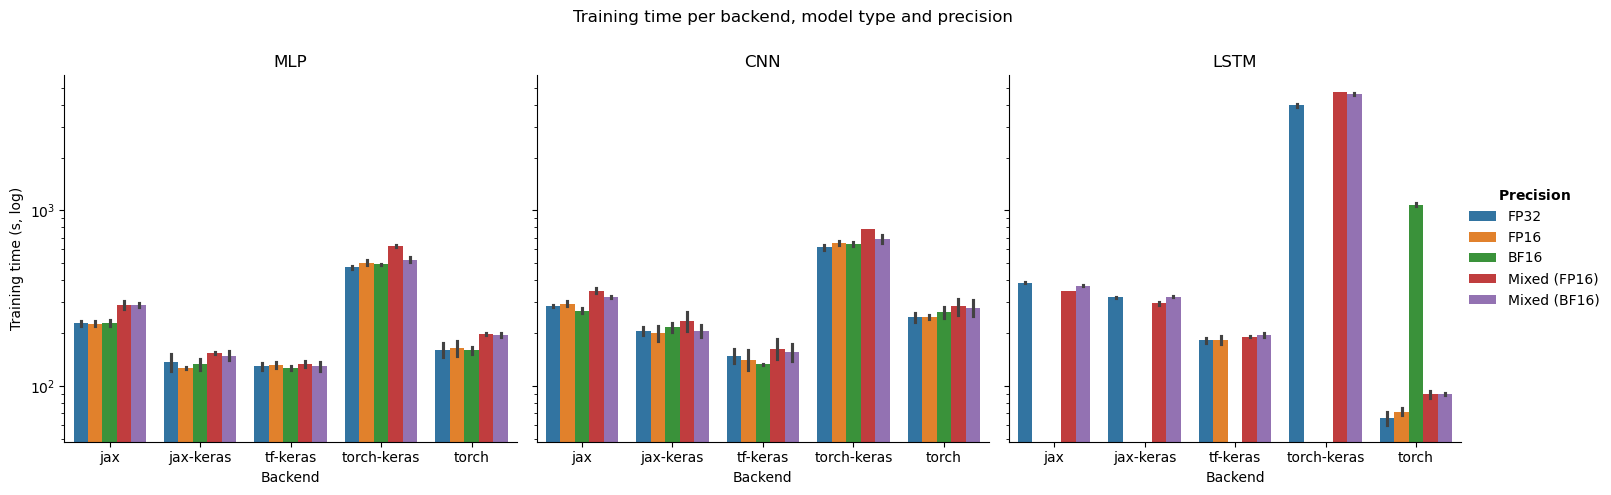

In [89]:
plot = sns.catplot(
    data=time_df,
    x="backend",
    y="training_time",
    hue="precision",
    col="model_type",
    kind="bar",
    order=backend_order,
    hue_order=precision_order,
    col_order=model_order,
    errorbar="sd"
)

# Title
add_title(plot, "Training time per backend, model type and precision")

plot.set(yscale="log")

plot.set_axis_labels("Backend", "Training time (s, log)")

plot._legend.set_title(r"$\bf{Precision}$")

for t in plot._legend.texts:
    txt: str = t.get_text()

    if txt.startswith("mixed"):
        parts = txt.split("_")
        txt = f"Mixed ({parts[1].upper()})"
    else:
        txt = txt.upper()
    t.set_text(txt)


plot.set_titles("{col_name}")
for ax in plot.axes.flat:
    ax.set_title(ax.get_title().upper())

### Testing time

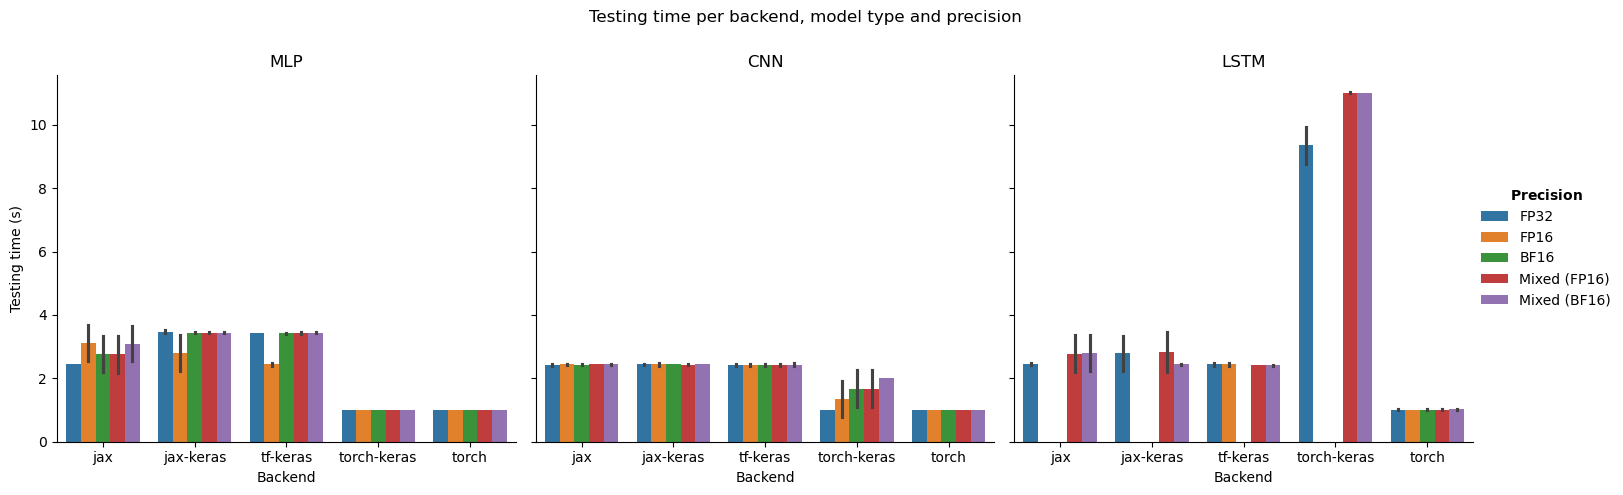

In [90]:
plot = sns.catplot(
    data=time_df,
    x="backend",
    y="testing_time",
    hue="precision",
    col="model_type",
    kind="bar",
    order=backend_order,
    hue_order=precision_order,
    col_order=model_order,
    errorbar="sd"
)

# Title
add_title(plot, "Testing time per backend, model type and precision")

plot.set_axis_labels("Backend", "Testing time (s)")

plot._legend.set_title(r"$\bf{Precision}$")

for t in plot._legend.texts:
    txt: str = t.get_text()

    if txt.startswith("mixed"):
        parts = txt.split("_")
        txt = f"Mixed ({parts[1].upper()})"
    else:
        txt = txt.upper()
    t.set_text(txt)


plot.set_titles("{col_name}")
for ax in plot.axes.flat:
    ax.set_title(ax.get_title().upper())

## GPU metrics

In [91]:
def exp_config_category(df):
    # Convert experiment config columns to categorical, for better performance
    orders = [backend_order, model_order, precision_order, seed_order]

    for col, order in zip(experiment_config, orders):
        df[col] = pd.Categorical(
            df[col],
            categories=order,
            ordered=True
        )
    
    return df

In [92]:
experiment_config = ["backend", "model_type", "precision", "seed"] # Remove model_complexity (is always "simple")
df_list = []

for keys, subset_df in index_df[index_df["filename"] == "train_samples"].groupby(experiment_config):
    backend, model_type, precision, seed = keys

    df = pd.read_csv(subset_df.iloc[0]["path"])

    df["backend"] = backend
    df["model_type"] = model_type
    df["precision"] = precision
    df["seed"] = seed

    df_list.append(df)

train_samples_df = pd.concat(df_list, ignore_index=True)

train_samples_df = exp_config_category(train_samples_df)

train_samples_df = train_samples_df.sort_values(by=experiment_config).reset_index(drop=True)

In [93]:
train_samples_df.head()

,timestamp,gpu_2_utilization,gpu_2_memory_used,gpu_2_power,backend,model_type,precision,seed
0,2.190392,0,62065.1875,64.923,jax,mlp,fp32,42
1,3.191456,0,62075.1875,63.950,jax,mlp,fp32,42
2,4.192263,9,62075.1875,65.681,jax,mlp,fp32,42
3,5.193223,0,62075.1875,64.644,jax,mlp,fp32,42
4,6.194193,0,62075.1875,64.436,jax,mlp,fp32,42


### GPU utilization

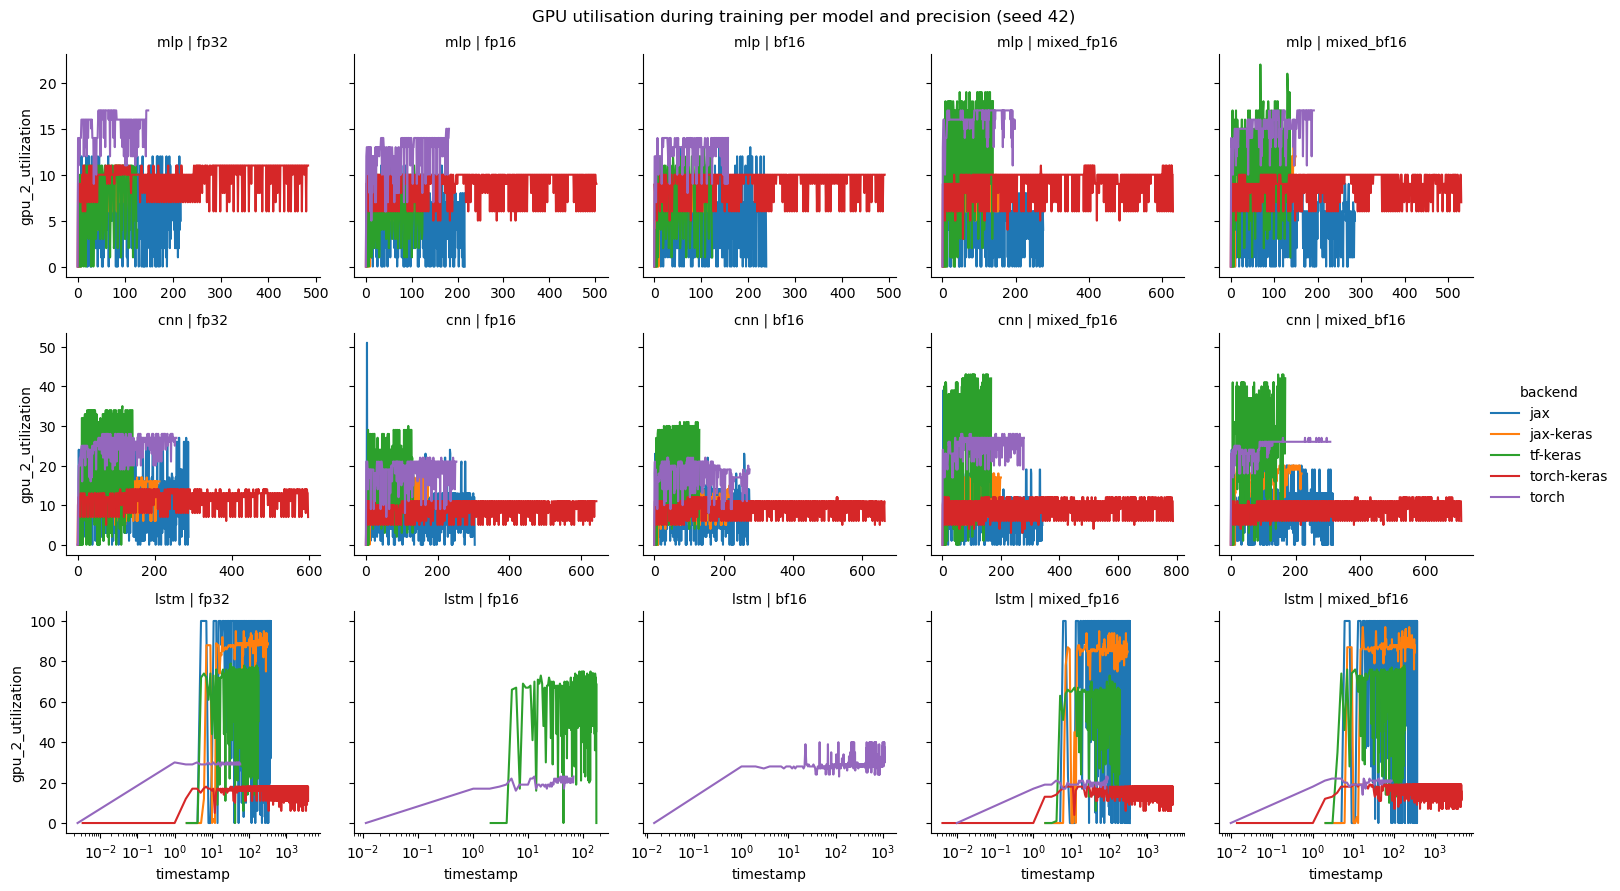

In [94]:
plot = sns.relplot(
    data=train_samples_df.query("seed == '42'"),
    x="timestamp",
    y="gpu_2_utilization",
    kind="line",
    hue="backend",
    col="precision",
    row="model_type",
    facet_kws={"sharey": "row", "sharex": False},
    hue_order=backend_order,
    col_order=precision_order,
    row_order=model_order,
    height=3
)

add_title(plot, "GPU utilisation during training per model and precision (seed 42)", adjust=0.93)

plot.set_titles(row_template="{row_name}", col_template="{col_name}")

for ax in plot.axes[-1]:
    ax.set_xscale("log")

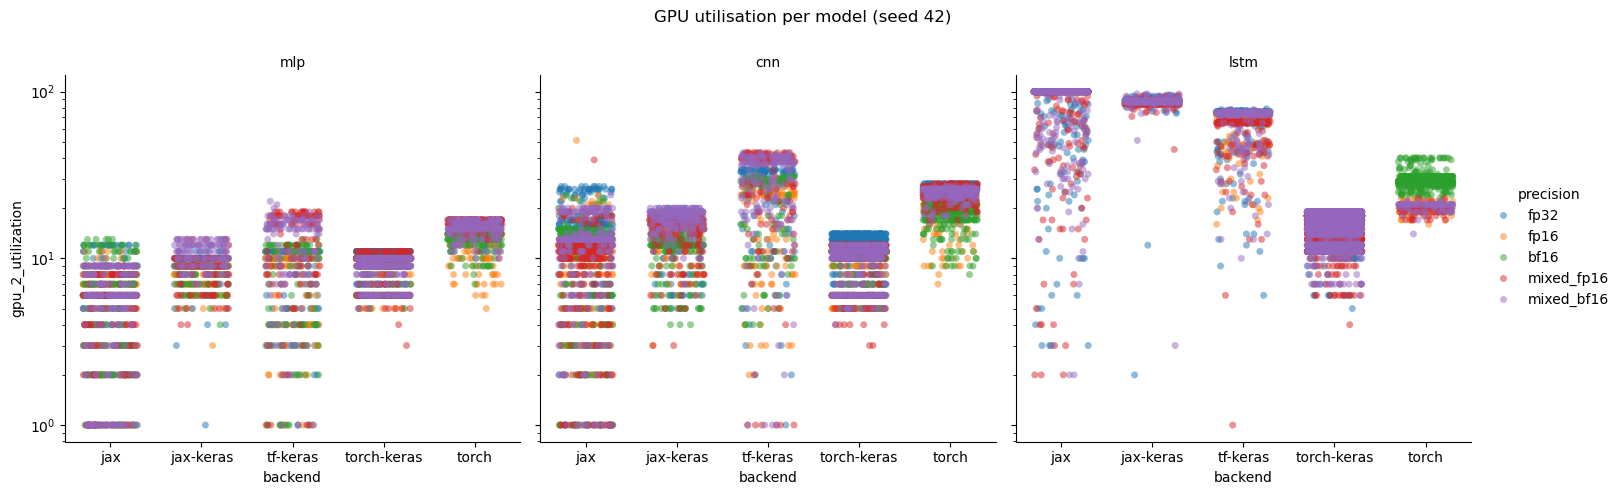

In [95]:
plot = sns.catplot(
    data=train_samples_df.query("seed == '42'"),
    x="backend",
    y="gpu_2_utilization",
    hue="precision",
    col="model_type",
    kind="strip",
    jitter="0.3",
    alpha=0.5,
)

add_title(plot, "GPU utilisation per model (seed 42)")

plot.set_titles(col_template="{col_name}")

plot.set(yscale="log")

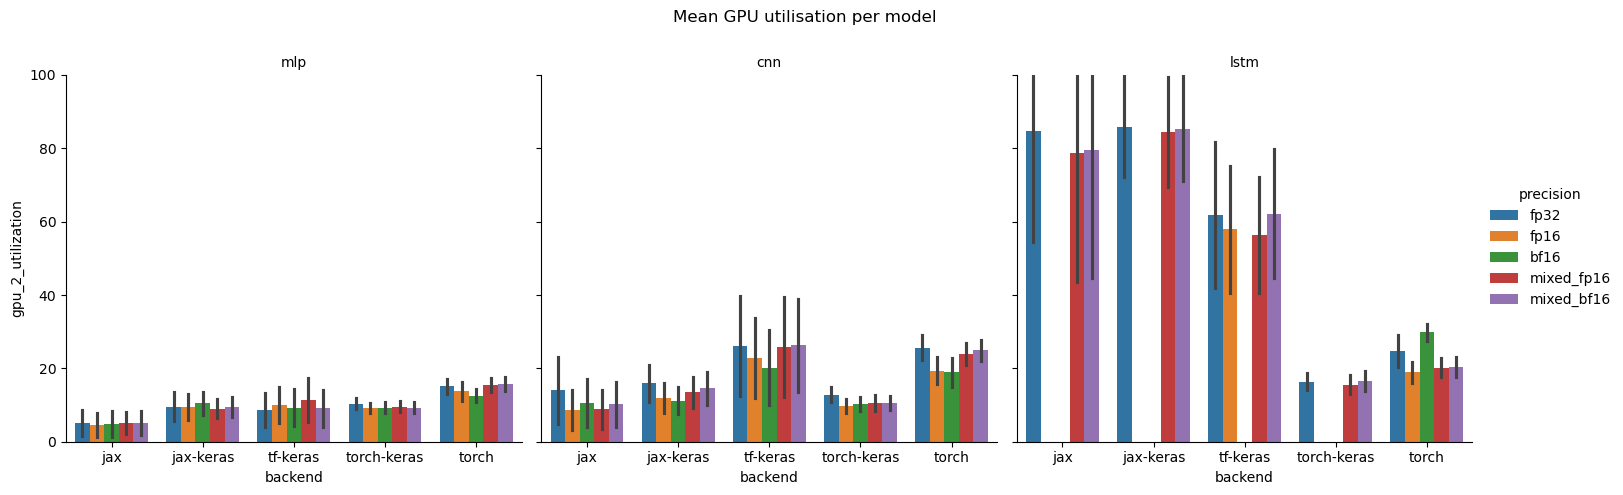

In [96]:
plot = sns.catplot(
    data=train_samples_df,
    x="backend",
    y="gpu_2_utilization",
    hue="precision",
    col="model_type",
    kind="bar",
    errorbar="sd"
)

add_title(plot, "Mean GPU utilisation per model")

plot.set_titles(col_template="{col_name}")

plot.set(ylim=(0, 100))

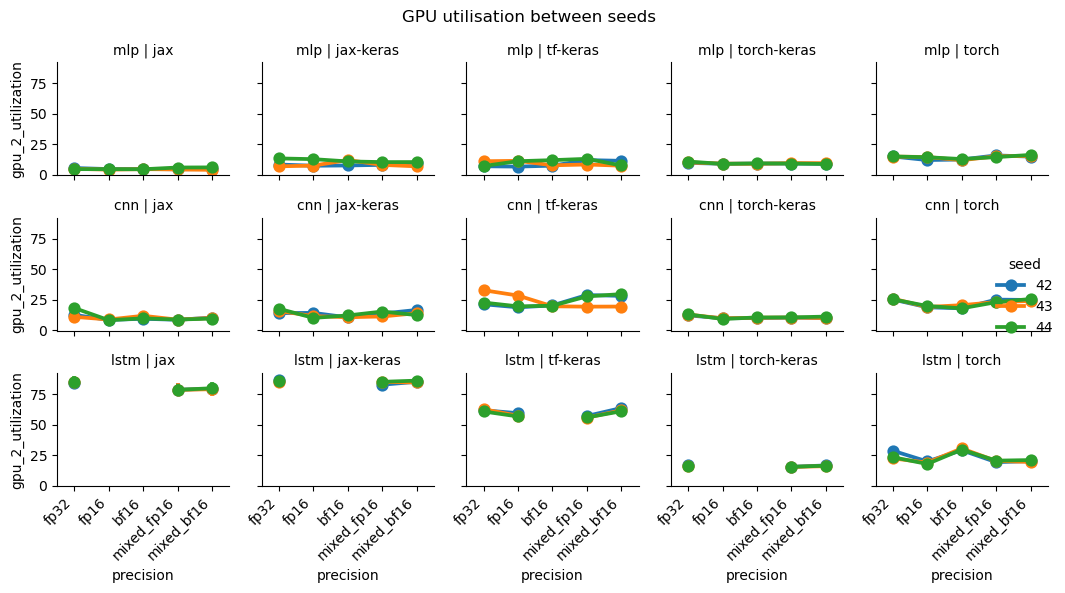

In [97]:
plot = sns.catplot(
    data=train_samples_df,
    x="precision",
    y="gpu_2_utilization",
    hue="seed",
    row="model_type",
    col="backend",
    kind="point",
    height=2
)

add_title(plot, "GPU utilisation between seeds")

plot.set_titles(row_template="{row_name}", col_template="{col_name}")

for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")


plt.tight_layout()


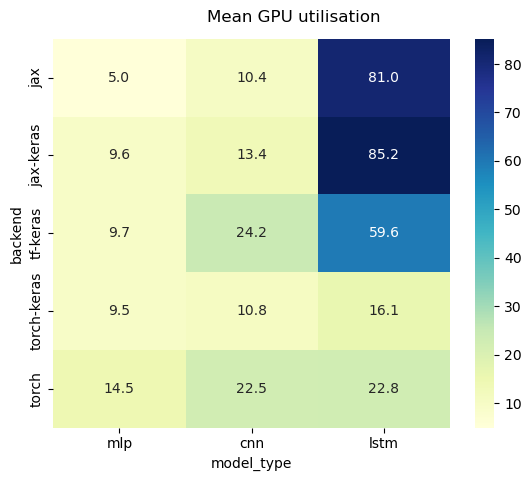

In [98]:
df_avg = train_samples_df.groupby(["backend","model_type","precision"])["gpu_2_utilization"].mean().reset_index()

df_pivot = df_avg.pivot_table(
    index="backend", columns="model_type", values="gpu_2_utilization"
)

plot = sns.heatmap(df_pivot, annot=True, fmt=".1f", cmap="YlGnBu")

add_title(plot, "Mean GPU utilisation", adjust=0.92)


### GPU memory

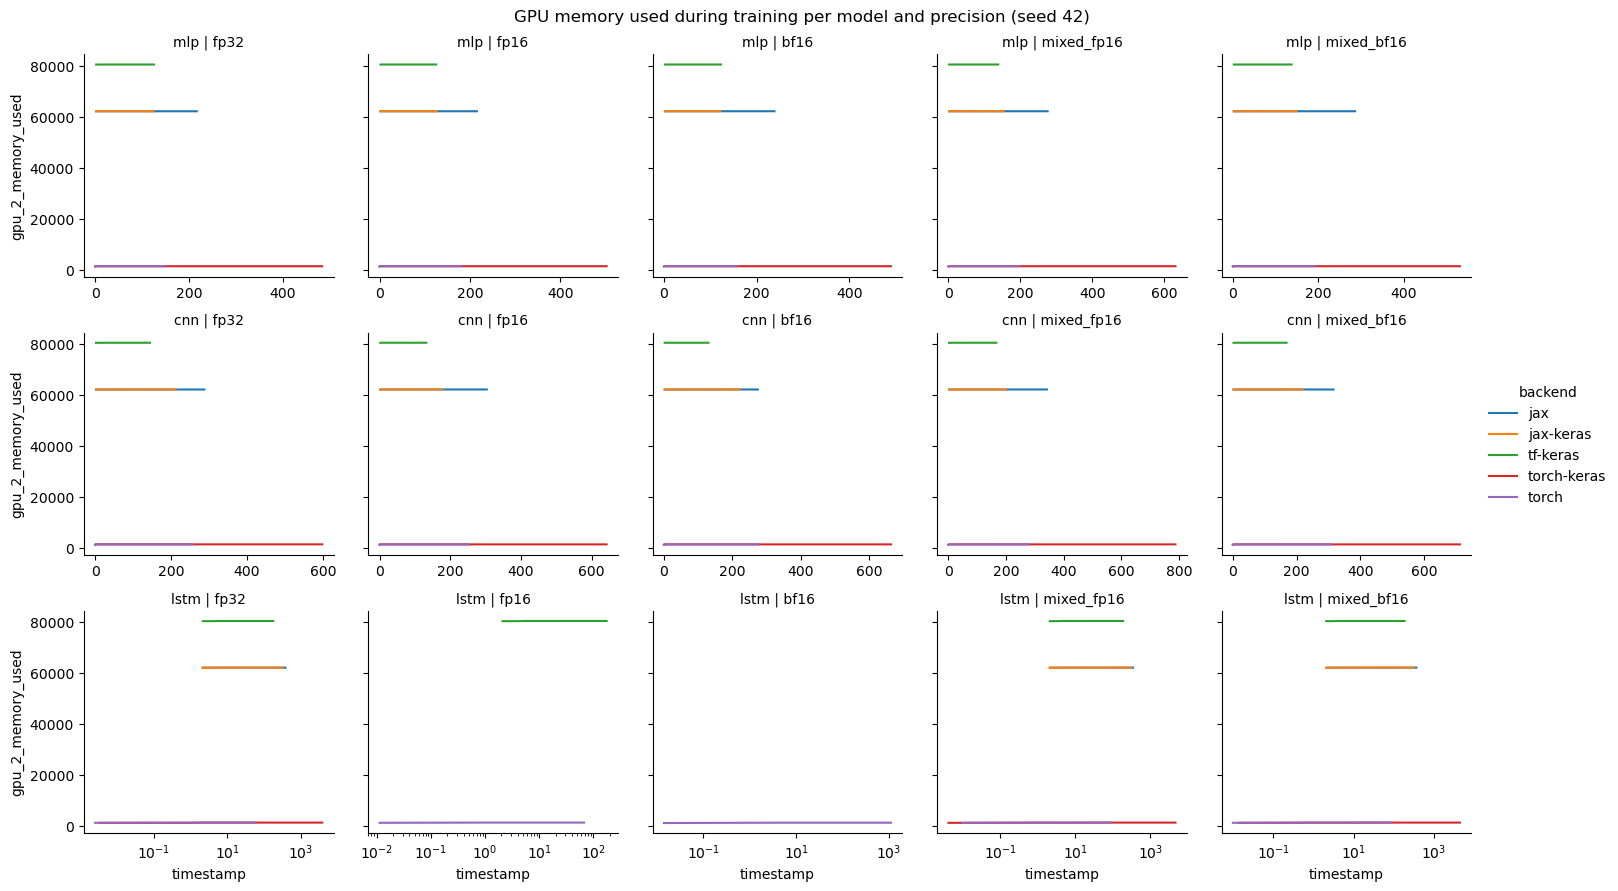

In [99]:
plot = sns.relplot(
    data=train_samples_df.query("seed == '42'"),
    x="timestamp",
    y="gpu_2_memory_used",
    kind="line",
    hue="backend",
    col="precision",
    row="model_type",
    facet_kws={"sharey": "row", "sharex": False},
    hue_order=backend_order,
    col_order=precision_order,
    row_order=model_order,
    height=3
)

add_title(plot, "GPU memory used during training per model and precision (seed 42)", adjust=0.93)

plot.set_titles(row_template="{row_name}", col_template="{col_name}")

for ax in plot.axes[-1]:
    ax.set_xscale("log")

In [100]:
memory_df = train_samples_df.groupby(["backend","model_type","precision"])["gpu_2_memory_used"].max().reset_index()
memory_df["max_memory"] = memory_df["gpu_2_memory_used"] / 1024  # Convert to GB
memory_df = memory_df.drop("gpu_2_memory_used", axis=1)
memory_df.head()

,backend,model_type,precision,max_memory
0,jax,mlp,fp32,60.622253
1,jax,mlp,fp16,60.630066
2,jax,mlp,bf16,60.630066
3,jax,mlp,mixed_fp16,60.630066
4,jax,mlp,mixed_bf16,60.630066


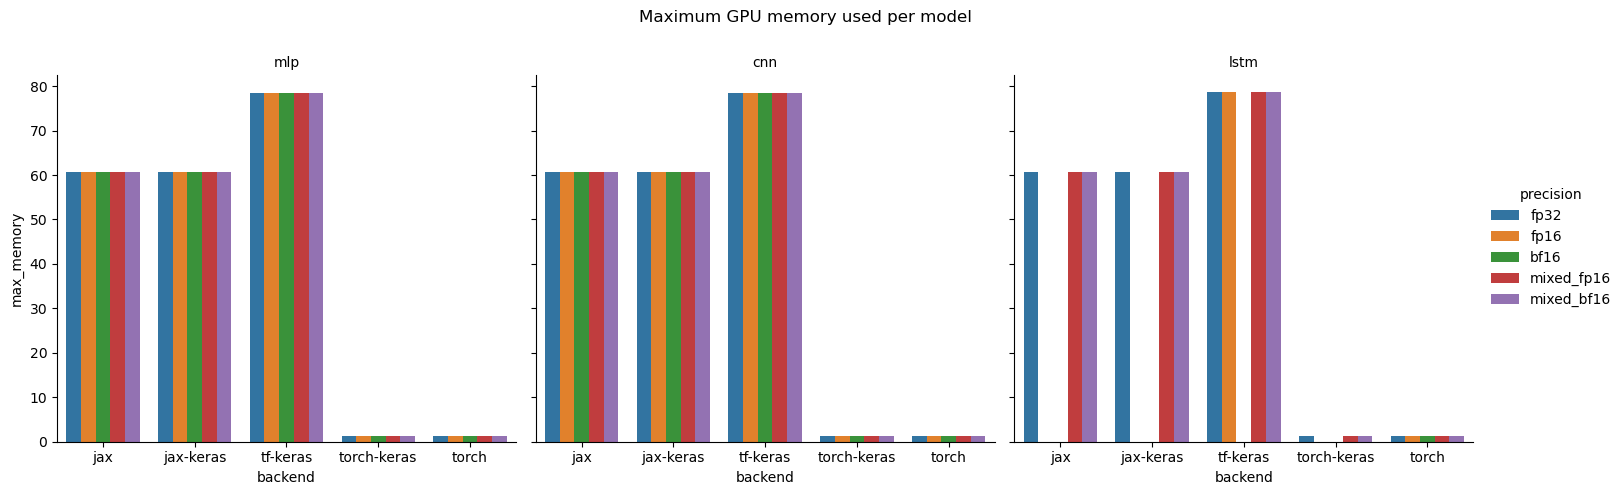

In [101]:
plot = sns.catplot(
    data=memory_df,
    x="backend",
    y="max_memory",
    hue="precision",
    col="model_type",
    kind="bar",
    errorbar="sd"
)

add_title(plot, "Maximum GPU memory used per model")

plot.set_titles(col_template="{col_name}")

In [102]:
memory_df = memory_df.groupby(["backend"])["max_memory"].max().sort_values(ascending=False).reset_index()
memory_df.head()

,backend,max_memory
0,tf-keras,78.569519
1,jax-keras,60.706238
2,jax,60.704285
3,torch,1.341003
4,torch-keras,1.329285


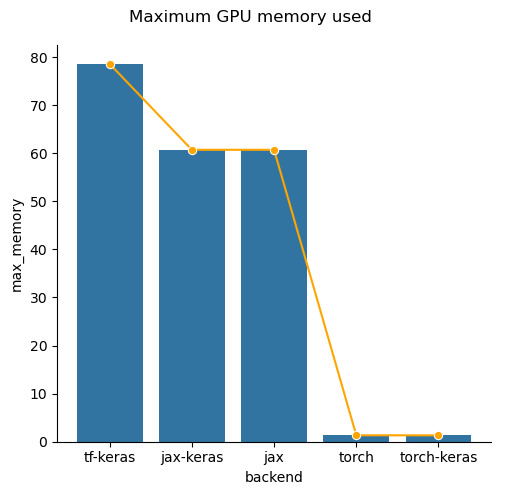

In [103]:
plot = sns.catplot(
    data=memory_df,
    x="backend",
    y="max_memory",
    kind="bar",
    errorbar="sd",
    order=memory_df["backend"]
)

sns.lineplot(
    x=memory_df["backend"],
    y=memory_df["max_memory"],
    ax=plot.ax,
    marker="o",
    color="orange"
)

add_title(plot, "Maximum GPU memory used")

plt.tight_layout()

### GPU Power

In [104]:
energy_df = train_samples_df[experiment_config + ["timestamp", "gpu_2_power"]]

energy_df = energy_df.sort_values(by=experiment_config + ["timestamp"]).reset_index(drop=True)
energy_df.head()

,backend,model_type,precision,seed,timestamp,gpu_2_power
0,jax,mlp,fp32,42,2.190392,64.923
1,jax,mlp,fp32,42,3.191456,63.950
2,jax,mlp,fp32,42,4.192263,65.681
3,jax,mlp,fp32,42,5.193223,64.644
4,jax,mlp,fp32,42,6.194193,64.436


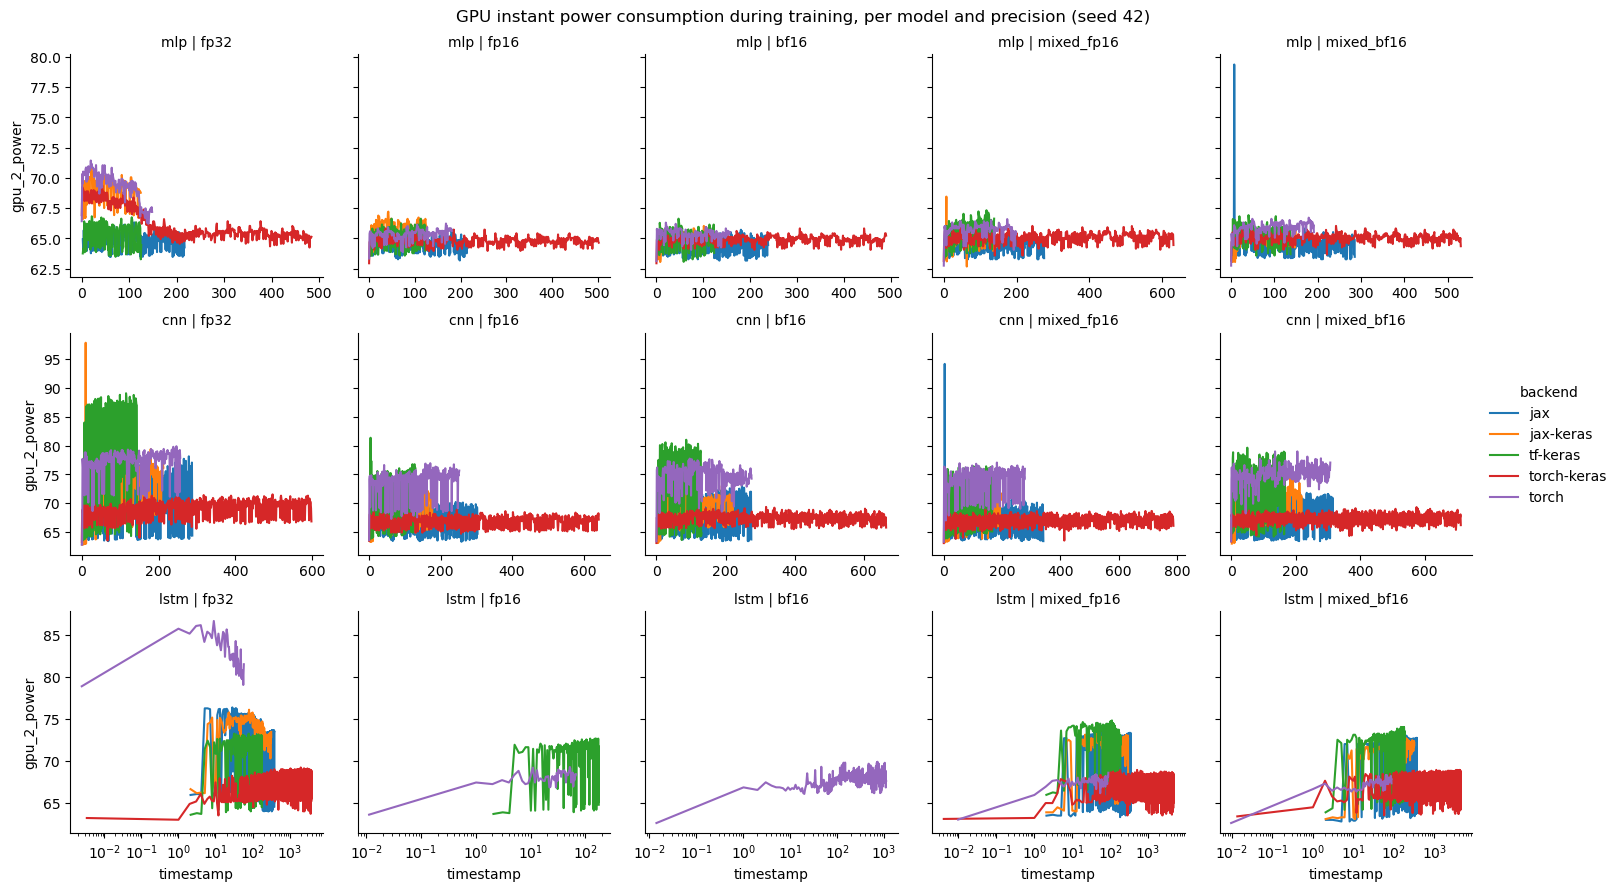

In [105]:
plot = sns.relplot(
    data=energy_df.query("seed == '42'"),
    x="timestamp",
    y="gpu_2_power",
    kind="line",
    hue="backend",
    col="precision",
    row="model_type",
    facet_kws={"sharey": "row", "sharex": False},
    hue_order=backend_order,
    col_order=precision_order,
    row_order=model_order,
    height=3
)

add_title(plot, "GPU instant power consumption during training, per model and precision (seed 42)", adjust=0.93)

plot.set_titles(row_template="{row_name}", col_template="{col_name}")

for ax in plot.axes[-1]:
    ax.set_xscale("log")

### GPU Energy Consumption

In [106]:
# Energy (J) = Power (W) * time (s)
energy_df["dt"] = energy_df.groupby(experiment_config)["timestamp"].diff().fillna(0)

energy_df["energy_j"] = energy_df["gpu_2_power"] * energy_df["dt"]
energy_df["energy_kwh"] = energy_df["energy_j"] / (1000 * 3600)
energy_df["cum_energy_kwh"] = energy_df.groupby(experiment_config)["energy_kwh"].cumsum()

energy_df.head()

,backend,model_type,precision,seed,timestamp,gpu_2_power,dt,energy_j,energy_kwh,cum_energy_kwh
0,jax,mlp,fp32,42,2.190392,64.923,0.000000,0.000000,0.000000,0.000000
1,jax,mlp,fp32,42,3.191456,63.950,1.001064,64.018032,0.000018,0.000018
2,jax,mlp,fp32,42,4.192263,65.681,1.000807,65.734008,0.000018,0.000036
3,jax,mlp,fp32,42,5.193223,64.644,1.000959,64.706019,0.000018,0.000054
4,jax,mlp,fp32,42,6.194193,64.436,1.000970,64.498511,0.000018,0.000072


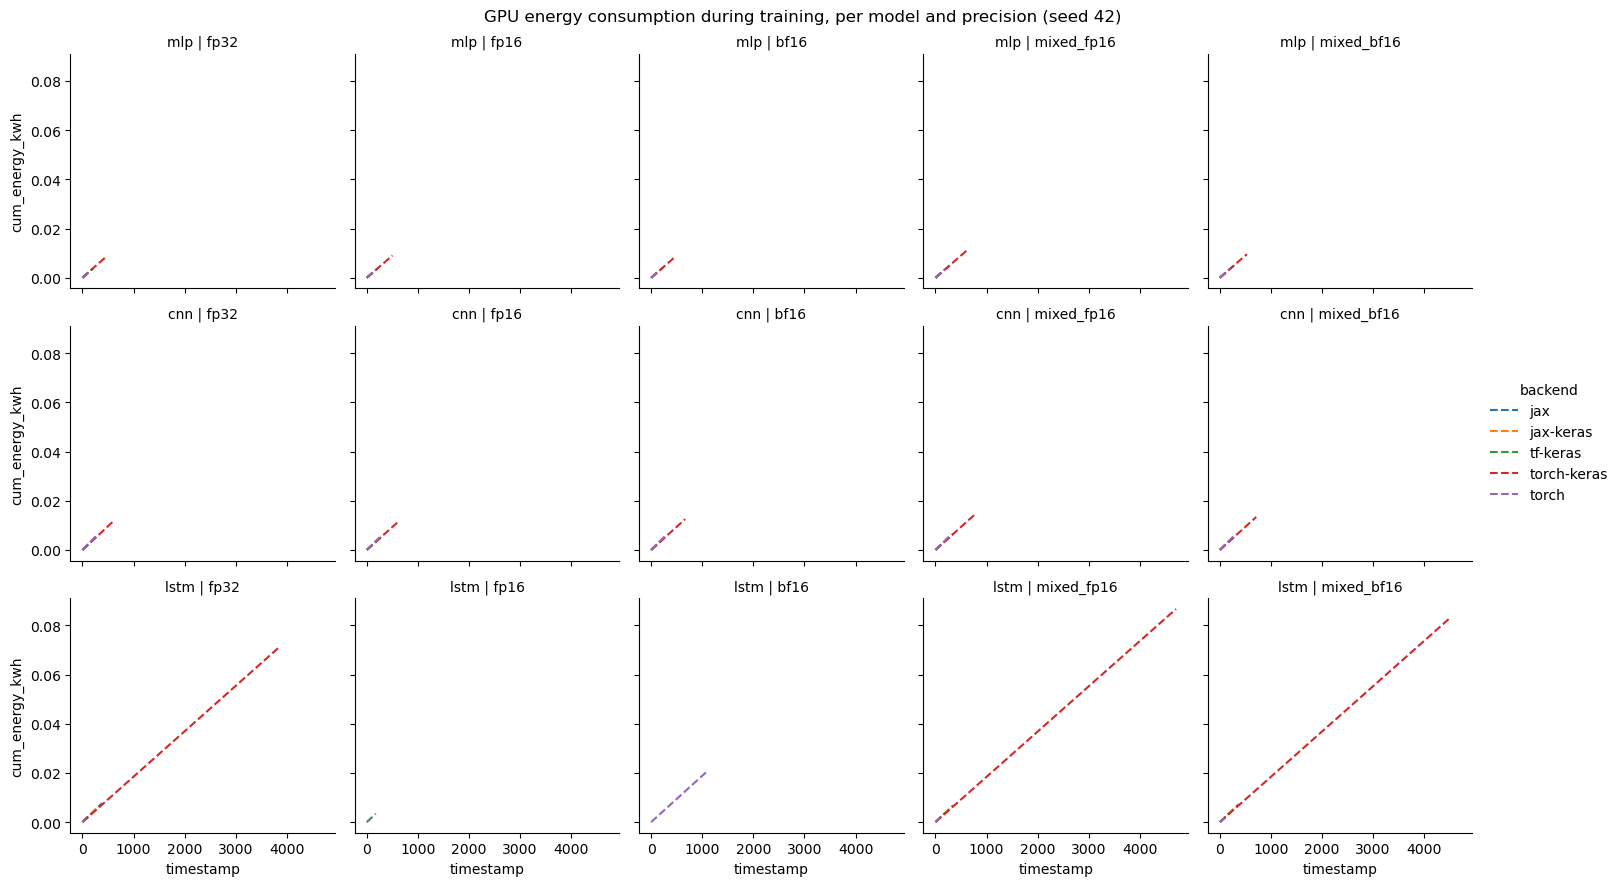

In [107]:
plot = sns.relplot(
    data=energy_df.query("seed == '42'"),
    x="timestamp",
    y="cum_energy_kwh",
    kind="line",
    hue="backend",
    col="precision",
    row="model_type",
    facet_kws={"sharey": True, "sharex": True},
    height=3,
    linestyle="--",
    alpha=1
)

add_title(plot, "GPU energy consumption during training, per model and precision (seed 42)", adjust=0.93)

plot.set_titles(row_template="{row_name}", col_template="{col_name}")


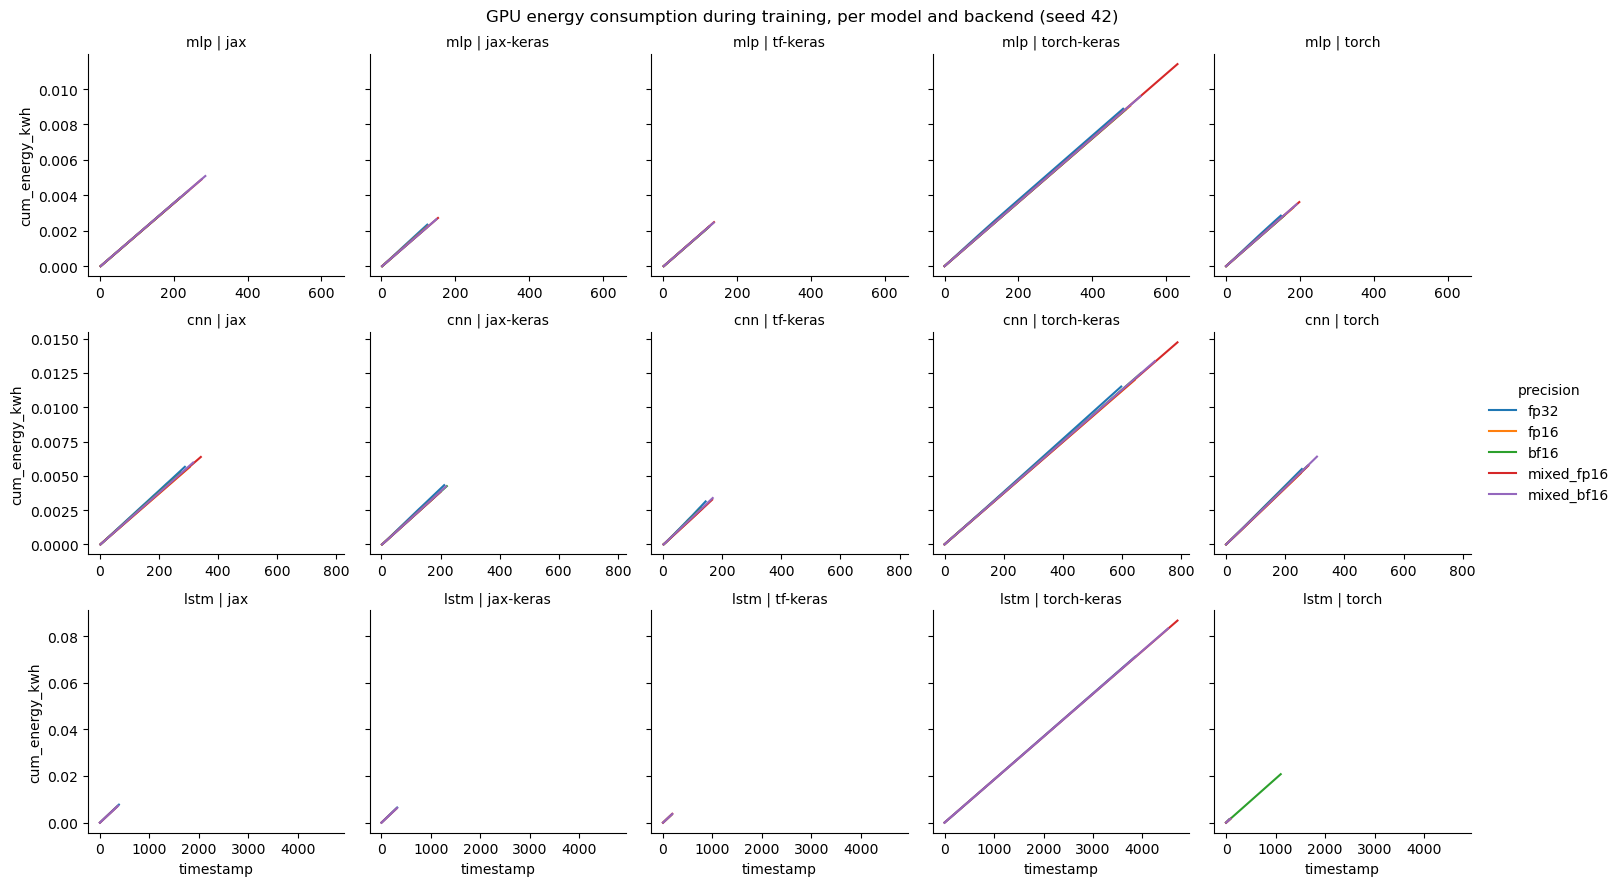

In [108]:
plot = sns.relplot(
    data=energy_df.query("seed == '42'"),
    x="timestamp",
    y="cum_energy_kwh",
    kind="line",
    hue="precision",
    col="backend",
    row="model_type",
    facet_kws={"sharey": "row", "sharex": "row"},
    height=3
)

add_title(plot, "GPU energy consumption during training, per model and backend (seed 42)", adjust=0.93)

plot.set_titles(row_template="{row_name}", col_template="{col_name}")


In [109]:

total_energy_df = (
    energy_df
    .groupby(experiment_config)["energy_kwh"]
    .sum()
    .reset_index()
    .rename(columns={"energy_kwh": "energy"})
)

total_energy_df.head()

,backend,model_type,precision,seed,energy
0,jax,mlp,fp32,42,0.003861
1,jax,mlp,fp32,43,0.004220
2,jax,mlp,fp32,44,0.004165
3,jax,mlp,fp16,42,0.003829
4,jax,mlp,fp16,43,0.004052


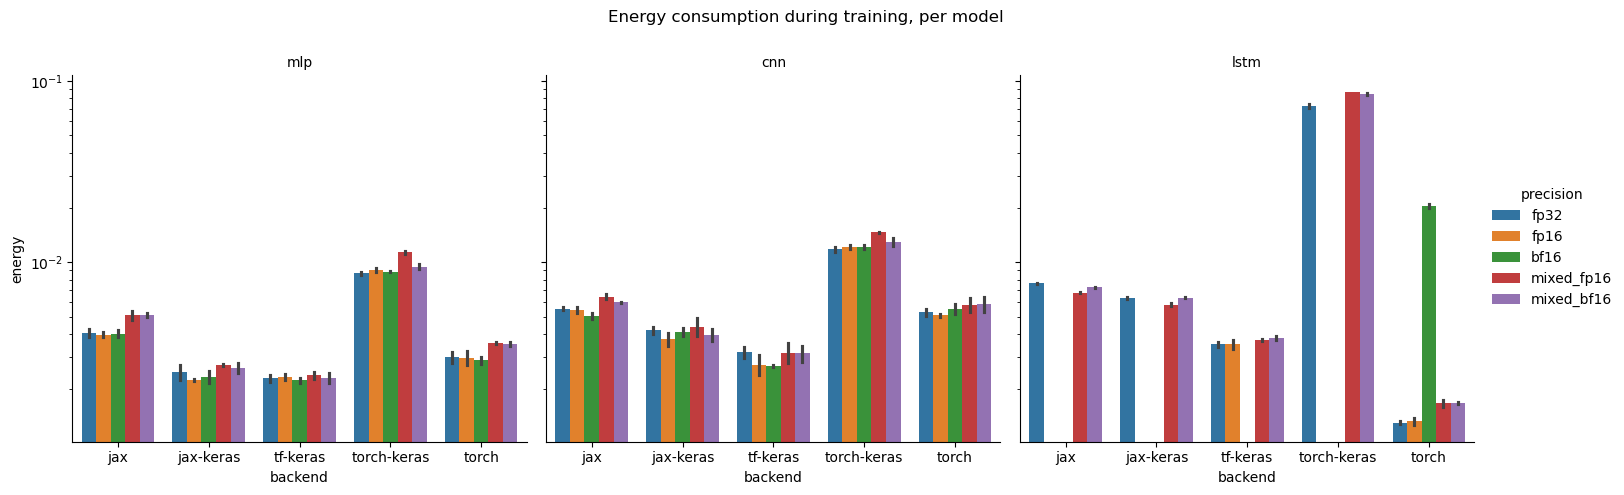

In [110]:
plot = sns.catplot(
    data=total_energy_df,
    x="backend",
    y="energy",
    hue="precision",
    col="model_type",
    kind="bar",
    errorbar="sd"
)

add_title(plot, "Energy consumption during training, per model")

plot.set_titles(col_template="{col_name}")

plot.set(yscale="log")

### GPU Energy per Hour

In [111]:
time_df["seed"] = time_df["seed"].astype(str)
time_df = exp_config_category(time_df)

time_df.head()

,backend,model_type,model_complexity,precision,seed,training_time,testing_time
0,jax,cnn,simple,bf16,42,276.151817,2.418015
1,jax,cnn,simple,bf16,43,258.165341,2.439186
2,jax,cnn,simple,bf16,44,272.022249,2.433130
3,jax,cnn,simple,fp16,42,305.029659,2.429303
4,jax,cnn,simple,fp16,43,283.138871,2.441872


In [112]:
total_energy_df = pd.merge(
    total_energy_df,
    time_df[experiment_config + ["training_time"]],
    on=experiment_config,
    how="left"
)

total_energy_df["energy_per_hour"] = total_energy_df["energy"] / (total_energy_df["training_time"] / 3600)

total_energy_df.head()

,backend,model_type,precision,seed,energy,training_time,energy_per_hour
0,jax,mlp,fp32,42,0.003861,218.031574,0.063745
1,jax,mlp,fp32,43,0.004220,234.050772,0.064911
2,jax,mlp,fp32,44,0.004165,229.041067,0.065461
3,jax,mlp,fp16,42,0.003829,217.017115,0.063512
4,jax,mlp,fp16,43,0.004052,231.114597,0.063124


In [113]:
total_energy_df.head()

,backend,model_type,precision,seed,energy,training_time,energy_per_hour
0,jax,mlp,fp32,42,0.003861,218.031574,0.063745
1,jax,mlp,fp32,43,0.004220,234.050772,0.064911
2,jax,mlp,fp32,44,0.004165,229.041067,0.065461
3,jax,mlp,fp16,42,0.003829,217.017115,0.063512
4,jax,mlp,fp16,43,0.004052,231.114597,0.063124


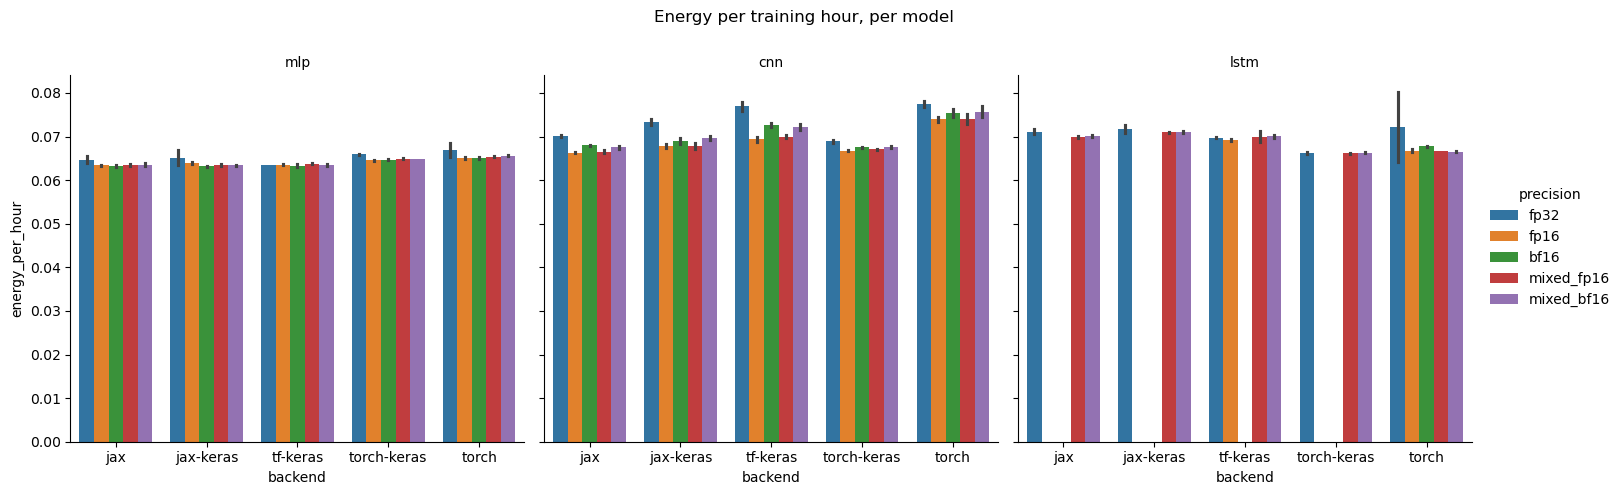

In [114]:
plot = sns.catplot(
    data=total_energy_df,
    x="backend",
    y="energy_per_hour",
    hue="precision",
    col="model_type",
    kind="bar",
    errorbar="sd"
)

add_title(plot, "Energy per training hour, per model")

plot.set_titles(col_template="{col_name}")

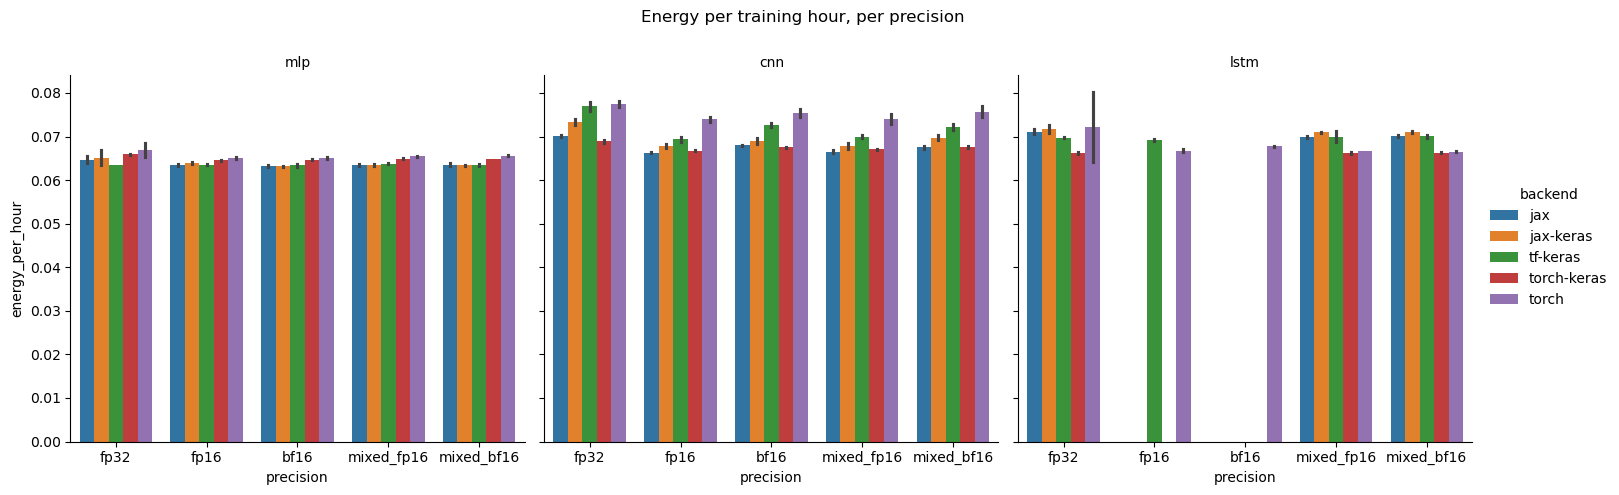

In [115]:
plot = sns.catplot(
    data=total_energy_df,
    x="precision",
    y="energy_per_hour",
    hue="backend",
    col="model_type",
    kind="bar",
    errorbar="sd"
)

add_title(plot, "Energy per training hour, per precision")

plot.set_titles(col_template="{col_name}")

In [116]:
total_energy_df.groupby(["backend", "model_type", ])["energy_per_hour"].mean().reset_index().query("model_type == 'lstm'")

,backend,model_type,energy_per_hour
2,jax,lstm,0.070396
5,jax-keras,lstm,0.071188
8,tf-keras,lstm,0.069722
11,torch-keras,lstm,0.066238
14,torch,lstm,0.067978


In [117]:
energy_sum_df = (
    total_energy_df
    .groupby(["backend"])
    .agg(
        total_energy=("energy", "sum"),
        total_time=("training_time", "sum")
    )
    .reset_index()
)

energy_sum_df["global_energy_per_hour"] = energy_sum_df["total_energy"] / (energy_sum_df["total_time"] / 3600)
energy_sum_df = energy_sum_df.sort_values(by="global_energy_per_hour", ascending=False)

max_value = energy_sum_df["global_energy_per_hour"].max()
energy_sum_df["improvement"] = 1 - energy_sum_df["global_energy_per_hour"] / max_value

energy_sum_df.head()

,backend,total_energy,total_time,global_energy_per_hour,improvement
4,torch,0.209534,10782.066215,0.069961,0.000000
2,tf-keras,0.122809,6436.453620,0.068689,0.018182
1,jax-keras,0.154261,8096.903640,0.068587,0.019639
0,jax,0.217552,11668.712486,0.067119,0.040625
3,torch-keras,1.066525,57916.238338,0.066294,0.052414


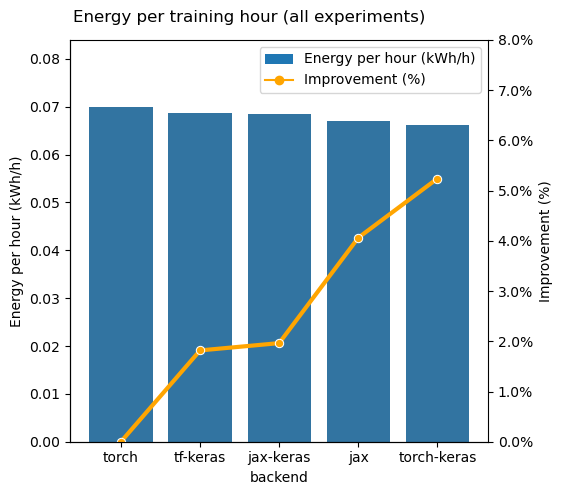

In [118]:
plot = sns.catplot(
    data=energy_sum_df,
    x="backend",
    y="global_energy_per_hour",
    kind="bar",
    errorbar="sd",
    order=energy_sum_df["backend"]
)

ax = plot.ax
ax.set_ylabel("Energy per hour (kWh/h)")
ax.set_ylim(0, max_value * 1.2)

ax2 = ax.twinx()
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_ylabel("Improvement (%)")
ax2.set_ylim(0, 0.08)

sns.lineplot(
    data=energy_sum_df,
    x="backend",
    y="improvement",
    ax=ax2,
    marker="o",
    color="orange",
    linewidth=3
)

add_title(plot, "Energy per training hour (all experiments)", adjust=0.92)

plot.set_titles(col_template="{col_name}")

legend_elements = [
    Patch(label="Energy per hour (kWh/h)"),
    Line2D([0], [0], color="orange", marker="o", label="Improvement (%)"),
]

ax.legend(handles=legend_elements, loc="best")


## Test results

In [119]:
df_list = []

for keys, subset_df in index_df[index_df["filename"] == "test"].groupby(experiment_config):
    backend, model_type, precision, seed = keys

    df = pd.read_csv(subset_df.iloc[0]["path"])

    df["backend"] = backend
    df["model_type"] = model_type
    df["precision"] = precision
    df["seed"] = seed

    df_list.append(df)

test_df = pd.concat(df_list, ignore_index=True)
test_df = exp_config_category(test_df)

test_df = test_df[experiment_config + ["time", "loss", "metric"]]
test_df = test_df.sort_values(by=experiment_config).reset_index(drop=True)

test_df.head()

,backend,model_type,precision,seed,time,loss,metric
0,jax,mlp,fp32,42,2.446716,0.282897,0.898985
1,jax,mlp,fp32,43,2.461142,0.284469,0.900876
2,jax,mlp,fp32,44,2.439721,0.287033,0.895999
3,jax,mlp,fp16,42,3.424967,NaN,0.100717
4,jax,mlp,fp16,43,3.440528,NaN,0.100717


In [120]:
failed_df: pd.DataFrame = (
    test_df.groupby(experiment_config)
    .apply(lambda g: g[["loss", "metric"]].isna().values.any())
    .reset_index(name="failed")
)

# Add experiments with errors
error_df["error"] = True

failed_df = failed_df.merge(
    error_df[experiment_config + ["error"]],
    on=experiment_config,
    how="outer"
)

failed_df["failed"] = failed_df["failed"].fillna(False)
failed_df["error"] = failed_df["error"].fillna(False)

failed_df.head()

/tmp/ipykernel_4055251/3708063559.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df.groupby(experiment_config)


,backend,model_type,precision,seed,failed,error
0,jax,cnn,bf16,42,False,False
1,jax,cnn,bf16,43,False,False
2,jax,cnn,bf16,44,False,False
3,jax,cnn,fp16,42,True,False
4,jax,cnn,fp16,43,True,False


In [121]:
num_failed_df = (
    failed_df.groupby(["precision", "seed"])
    .apply(lambda g: pd.Series({
        "num_success": (~g["failed"] & ~g["error"]).sum(),
        "num_failed": g["failed"].sum(),
        "num_error": g["error"].sum()
    }))
    .reset_index()
)

num_failed_df["precision"] = pd.Categorical(
    num_failed_df["precision"],
    categories=precision_order,
    ordered=True
)
num_failed_df = num_failed_df.sort_values(by="precision")

num_failed_df.head()

/tmp/ipykernel_4055251/237086042.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  failed_df.groupby(["precision", "seed"])


,precision,seed,num_success,num_failed,num_error
6,fp32,42,15,0,0
7,fp32,43,15,0,0
8,fp32,44,15,0,0
3,fp16,42,3,9,3
4,fp16,43,3,9,3


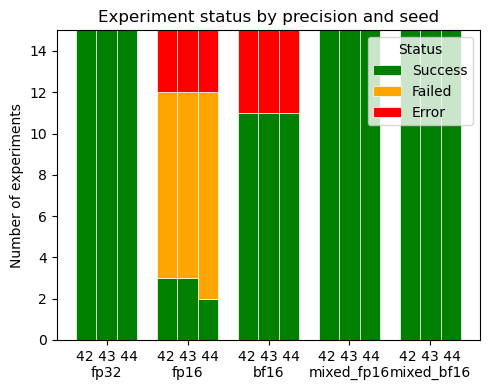

In [122]:
colors = {
    "num_success": "green",
    "num_failed":  "orange",
    "num_error":   "red"
}

x = np.arange(len(precision_order)) # base positions
bar_width = 0.25

fig, ax = plt.subplots(figsize=(5,4))

for i, seed in enumerate(seed_order):
    subset = num_failed_df[num_failed_df["seed"] == seed]
    bottoms = np.zeros(len(subset))
    for col in ["num_success", "num_failed", "num_error"]:
        ax.bar(
            x + i * bar_width, # Move each seed bars
            subset[col].values,
            bar_width,
            bottom=bottoms,
            color=colors[col],
            linewidth=0.5,
            edgecolor="white"
        )
        bottoms += subset[col].values


ax.set_xticks(x + bar_width)
ax.set_xticklabels([f"42 43 44\n{precision}" for precision in precision_order])

ax.set_ylabel("Number of experiments")

ax.set_title("Experiment status by precision and seed")
ax.legend(["Success","Failed","Error"], title="Status", loc="upper right")

plt.tight_layout()
plt.show()

In [123]:
num_failed_df[["num_success", "num_failed", "num_error"]].sum()

num_success    176
num_failed      28
num_error       21
dtype: int64

In [124]:
test_metric_df = test_df.melt(
    id_vars=experiment_config,
    value_vars=["loss", "metric"],
    var_name="measure",
    value_name="value"
)
test_metric_df.head()

,backend,model_type,precision,seed,measure,value
0,jax,mlp,fp32,42,loss,0.282897
1,jax,mlp,fp32,43,loss,0.284469
2,jax,mlp,fp32,44,loss,0.287033
3,jax,mlp,fp16,42,loss,NaN
4,jax,mlp,fp16,43,loss,NaN


In [125]:
def plot_test_results(model_type: str, loss_name: str, metric_name: str, log=False):
    df = test_df[test_df["model_type"] == model_type]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    sns.barplot(
        data=df,
        x="backend",
        y="loss",
        hue="precision",
        ax=axes[0]
    )

    axes[0].set_title(f"Loss ({loss_name})")
    axes[0].set_xlabel("Framework")
    axes[0].set_ylabel("Loss")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
    axes[0].legend_.remove()


    sns.barplot(
        data=df,
        x="backend",
        y="metric",
        hue="precision",
        ax=axes[1]
    )

    axes[1].set_title(f"{metric_name}")
    axes[1].set_xlabel("Framework")
    axes[1].set_ylabel(f"{metric_name}")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
    axes[1].legend_.remove()

    # Legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1),
        ncol=len(labels)
    )

    fig.suptitle(f"Test results ({model_type.upper()})", y=1.05)

    if log:
        for _, ax in enumerate(axes.flat):
            ax.set(yscale="log")
            ax.set_ylabel(ax.get_ylabel() + " (log)")

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_4055251/687624313.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_4055251/687624313.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


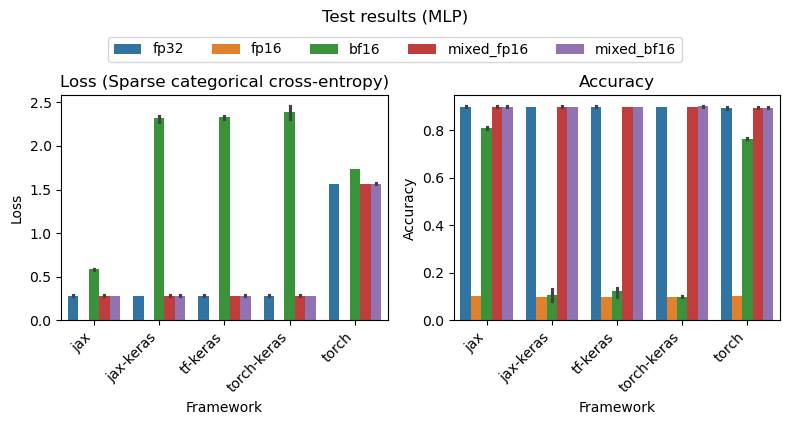

In [126]:
plot_test_results("mlp", "Sparse categorical cross-entropy", "Accuracy")

/tmp/ipykernel_4055251/687624313.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_4055251/687624313.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


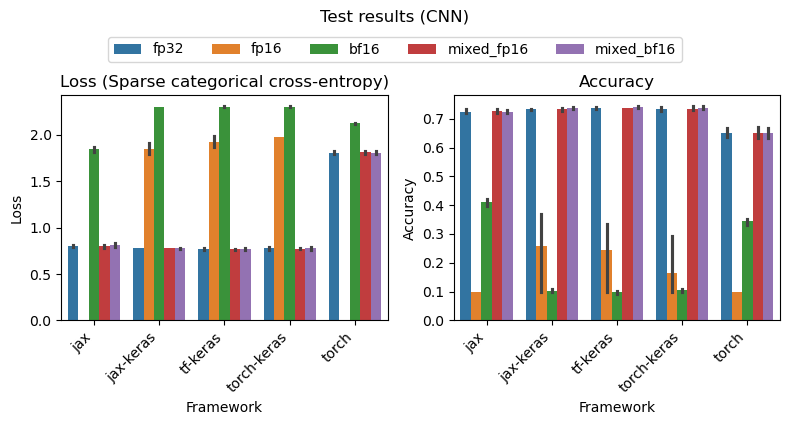

In [127]:
plot_test_results("cnn", "Sparse categorical cross-entropy", "Accuracy")

/tmp/ipykernel_4055251/687624313.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_4055251/687624313.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


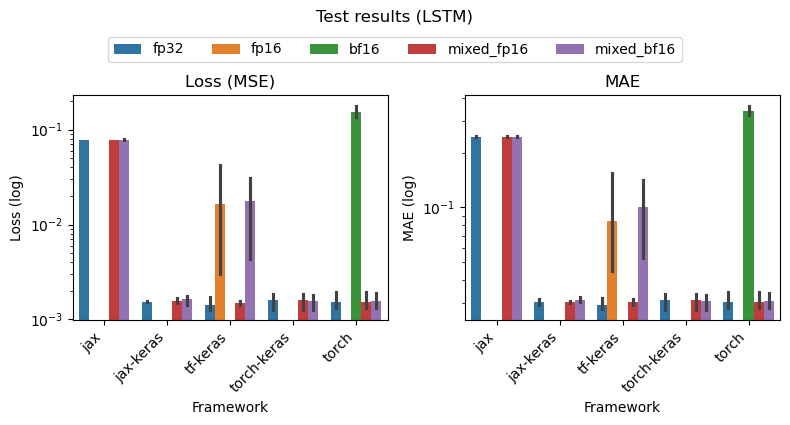

In [128]:
plot_test_results("lstm", "MSE", "MAE", log=True)

## Mixed metrics graphs

### Correlation

In [158]:
total_energy_df.head()

,backend,model_type,precision,seed,energy,training_time,energy_per_hour
0,jax,mlp,fp32,42,0.003861,218.031574,0.063745
1,jax,mlp,fp32,43,0.004220,234.050772,0.064911
2,jax,mlp,fp32,44,0.004165,229.041067,0.065461
3,jax,mlp,fp16,42,0.003829,217.017115,0.063512
4,jax,mlp,fp16,43,0.004052,231.114597,0.063124


In [160]:
# Remove error experiments
df = total_energy_df[~total_energy_df["training_time"].isna()].copy()
df = df.sort_values(by=["model_type"])

results = []

for keys, group in df.groupby(["model_type"]):
    
    corr = group["training_time"].corr(group["energy"])

    X = group[["training_time"]].values
    y = group["energy"].values

    modelo = LinearRegression().fit(X, y)

    slope_w = modelo.coef_[0] * 1000 * 3600 # kWh/s -> J/s = W
    intercept = modelo.intercept_
    r2 = modelo.score(X, y)

    results.append({
        "model_type": keys[0],
        "correlation": corr,
        "mean_power_W": slope_w,
        "intercept_kwh": intercept,
        "R2": r2
    })

results_df = pd.DataFrame(results)

results_df.head()

,model_type,correlation,mean_power_W,intercept_kwh,R2
0,mlp,0.999754,65.162000,-0.000046,0.999508
1,cnn,0.998028,65.838486,0.000326,0.996060
2,lstm,0.999979,66.046836,0.000267,0.999959


### Comparison plots

In [61]:
mixed_df = time_df.merge(
    memory_df,
    on="backend",
    how="left"
)

mixed_df = mixed_df.merge(
    test_df,
    on=experiment_config,
    how="left"
)

mixed_df = (
    mixed_df.groupby(experiment_config[:-1])[["training_time", "max_memory", "loss", "metric"]].mean().reset_index()    
)

mixed_df.head()

,backend,model_type,precision,training_time,max_memory,loss,metric
0,jax,mlp,fp32,227.041138,60.704285,0.284800,0.898620
1,jax,mlp,fp16,226.399549,60.704285,NaN,0.100717
2,jax,mlp,bf16,229.423288,60.704285,0.585938,0.808785
3,jax,mlp,mixed_fp16,289.856735,60.704285,0.284912,0.899483
4,jax,mlp,mixed_bf16,290.166606,60.704285,0.281901,0.898952


In [171]:
mem_df = mixed_df.copy()
mem_df['metric'] = 'Memory'
mem_df['value'] = mem_df['max_memory']

loss_df = mixed_df.copy()
loss_df['metric'] = 'Loss'
loss_df['value'] = loss_df['loss']

mixed_df = pd.concat([mem_df, loss_df], axis=0)

mixed_df["metric"] = pd.Categorical(mixed_df["metric"], categories=["Memory", "Loss"], ordered=True)
mixed_df.sort_values(by=experiment_config[:-1] + ["metric"])

mixed_df.head()

NameError: name 'mixed_df' is not defined

In [172]:
plot = sns.relplot(
    data=mixed_df,
    x="training_time", y="value",
    hue="backend", style="precision",
    markers=precision_markers,
    col="metric", row="model_type",
    facet_kws={"sharex": False, "sharey": False},
)

# Plot titles
plot.set_titles(row_template="{row_name}", col_template="{col_name}")

# Add space between rows (for labels)
plot.figure.subplots_adjust(hspace=0.25)

# Adjust labels per column
for ax, metric in zip(plot.axes[0], ['Memory', 'Loss']):
    if metric == 'Memory':
        ax.set_ylabel("Max memory (GB)")
    else:
        ax.set_ylabel("Loss")

# log-x only for LSTM row
for model, axs in zip(model_order, plot.axes):
    if str(model).lower() == "lstm":
        for ax in axs:
            ax.set(xscale="log")
            ax.set_xlabel("Training time (log)")
    else:
        for ax in axs:
            ax.set_xlabel("Training time")


# Grid
for ax in plot.axes.flat:
    ax.grid(True, ls=":", alpha=.4)


for ax, (keys, sub) in zip(plot.axes.flat, mixed_df.groupby(['model_type', 'metric'])):
    model, metric = keys

    # Quartiles
    x25, x_med, x75 = sub['training_time'].quantile([.25, .5, .75])
    y25, y_med, y75 = sub['value'].quantile([.25, .5, .75])

    # Median lines
    ax.axvline(x_med, ls="--", lw=1, color="grey")
    ax.axhline(y_med, ls="--", lw=1, color="grey")
    
    # Shading by quartiles
    ax.axvspan(x25, x75, color="grey", alpha=.08)
    ax.axhspan(y25, y75, color="grey", alpha=.08)

    # Pareto frontier
    df2 = sub.query("metric == @metric")[['training_time', 'value']].sort_values('training_time')

    best = np.inf # In all three metrics, a lower value is preferred
    pareto = []
    for _, r in df2.iterrows():
        if r['value'] < best:
            pareto.append((r['training_time'], r['value']))
            best = r['value']

    pareto = np.array(pareto)
    ax.plot(pareto[:,0], pareto[:,1], lw=1.5, color="black", label="Pareto")

    # Annotate Pareto points
    pareto_df = pd.merge(
        sub,
        pd.DataFrame(pareto, columns=['training_time','value']),
        on=['training_time','value']
    )
    
    texts = []
    for i, r in pareto_df.iterrows():
        texts.append(
            ax.text(r.training_time, r.value,
                    f"{r.backend}/{r.precision}",
                    fontsize=9)
        )
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", lw=0.5))

plot.add_legend()


NameError: name 'mixed_df' is not defined

In [173]:
total_energy_df.head()

,backend,model_type,precision,seed,energy,training_time,energy_per_hour
0,jax,mlp,fp32,42,0.003861,218.031574,0.063745
1,jax,mlp,fp32,43,0.004220,234.050772,0.064911
2,jax,mlp,fp32,44,0.004165,229.041067,0.065461
3,jax,mlp,fp16,42,0.003829,217.017115,0.063512
4,jax,mlp,fp16,43,0.004052,231.114597,0.063124


In [174]:
mixed_df = total_energy_df.merge(
    memory_df,
    on="backend",
    how="left"
)

mixed_df = mixed_df.merge(
    test_df,
    on=experiment_config,
    how="left"
)

mixed_df = (
    mixed_df.groupby(experiment_config[:-1])[["energy", "training_time", "max_memory", "loss", "metric"]].mean().reset_index()    
)

mixed_df.head()

,backend,model_type,precision,energy,training_time,max_memory,loss,metric
0,jax,mlp,fp32,0.004082,227.041138,60.704285,0.284800,0.898620
1,jax,mlp,fp16,0.003985,226.399549,60.704285,NaN,0.100717
2,jax,mlp,bf16,0.004030,229.423288,60.704285,0.585938,0.808785
3,jax,mlp,mixed_fp16,0.005109,289.856735,60.704285,0.284912,0.899483
4,jax,mlp,mixed_bf16,0.005117,290.166606,60.704285,0.281901,0.898952


In [175]:
mem_df = mixed_df.copy()
mem_df['metric'] = 'Memory'
mem_df['value'] = mem_df['max_memory']

loss_df = mixed_df.copy()
loss_df['metric'] = 'Loss'
loss_df['value'] = loss_df['loss']

mixed_df = pd.concat([mem_df, loss_df], axis=0)

# Distinct between valid and invalid experiments (error experiment -> energy = 0)
mixed_df["valid"] = (mixed_df["energy"] > 0) & (~mixed_df["loss"].isna())

mixed_df["metric"] = pd.Categorical(mixed_df["metric"], categories=["Memory", "Loss"], ordered=True)
mixed_df.sort_values(by=experiment_config[:-1] + ["metric"])

mixed_df.head()

,backend,model_type,precision,energy,training_time,max_memory,loss,metric,value,valid
0,jax,mlp,fp32,0.004082,227.041138,60.704285,0.284800,Memory,60.704285,True
1,jax,mlp,fp16,0.003985,226.399549,60.704285,NaN,Memory,60.704285,False
2,jax,mlp,bf16,0.004030,229.423288,60.704285,0.585938,Memory,60.704285,True
3,jax,mlp,mixed_fp16,0.005109,289.856735,60.704285,0.284912,Memory,60.704285,True
4,jax,mlp,mixed_bf16,0.005117,290.166606,60.704285,0.281901,Memory,60.704285,True


In [176]:
total_energy_df.head()

,backend,model_type,precision,seed,energy,training_time,energy_per_hour
0,jax,mlp,fp32,42,0.003861,218.031574,0.063745
1,jax,mlp,fp32,43,0.004220,234.050772,0.064911
2,jax,mlp,fp32,44,0.004165,229.041067,0.065461
3,jax,mlp,fp16,42,0.003829,217.017115,0.063512
4,jax,mlp,fp16,43,0.004052,231.114597,0.063124


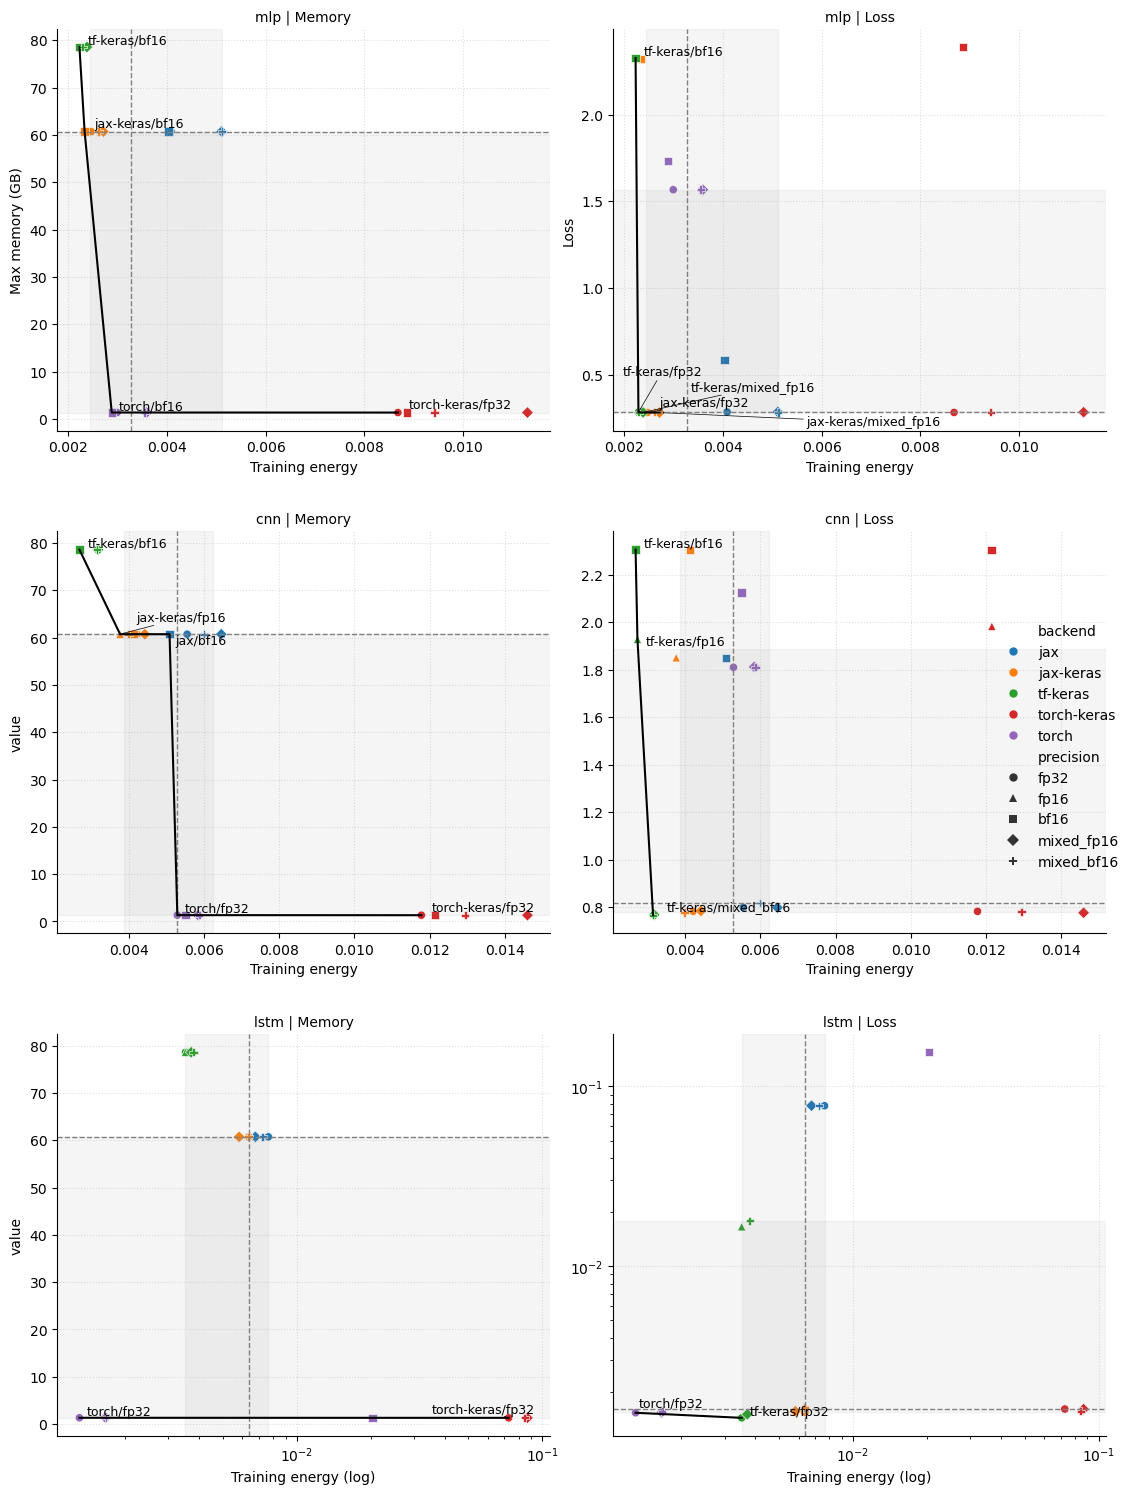

In [177]:
valid_df = mixed_df[mixed_df["valid"]]

precision_markers = {
    "fp32": "o",
    "bf16": "s",
    "fp16": "^",
    "mixed_fp16": "D",
    "mixed_bf16": "P"
}

plot = sns.relplot(
    data=valid_df,
    x="energy",
    y="value",
    hue="backend",
    style="precision",
    markers=precision_markers,
    col="metric",
    row="model_type",
    facet_kws={"sharex": False, "sharey": False},
)

# Plot titles
plot.set_titles(row_template="{row_name}", col_template="{col_name}")

# Add space between rows (for labels)
plot.figure.subplots_adjust(hspace=0.25)

# Adjust labels per column
for ax, metric in zip(plot.axes[0], ['Memory', 'Loss']):
    if metric == 'Memory':
        ax.set_ylabel("Max memory (GB)")
    else:
        ax.set_ylabel("Loss")

# log-x only for LSTM row
for model, axs in zip(model_order, plot.axes):
    if str(model).lower() == "lstm":
        for ax in axs:
            ax.set(xscale="log")
            ax.set_xlabel("Training energy (log)")
        axs[-1].set(yscale="log")
    else:
        for ax in axs:
            ax.set_xlabel("Training energy")


# Grid
for ax in plot.axes.flat:
    ax.grid(True, ls=":", alpha=.4)


for ax, (keys, df) in zip(plot.axes.flat, valid_df.groupby(['model_type', 'metric'])):
    model, metric = keys

    # Quartiles
    x25, x_med, x75 = df['energy'].quantile([.25, .5, .75])
    y25, y_med, y75 = df['value'].quantile([.25, .5, .75])

    # Median lines
    ax.axvline(x_med, ls="--", lw=1, color="grey")
    ax.axhline(y_med, ls="--", lw=1, color="grey")
    
    # Shading by quartiles
    ax.axvspan(x25, x75, color="grey", alpha=.08)
    ax.axhspan(y25, y75, color="grey", alpha=.08)

    # Pareto frontier
    df2 = df.query("metric == @metric")[['energy', 'value']].sort_values('energy')

    best = np.inf # In all three metrics, a lower value is preferred
    pareto = []
    for _, r in df2.iterrows():
        if r['value'] < best:
            pareto.append((r['energy'], r['value']))
            best = r['value']

    pareto = np.array(pareto)
    ax.plot(pareto[:,0], pareto[:,1], lw=1.5, color="black", label="Pareto")

    # Annotate Pareto points
    pareto_df = pd.merge(
        df,
        pd.DataFrame(pareto, columns=['energy','value']),
        on=['energy','value']
    )
    
    texts = []
    for i, r in pareto_df.iterrows():
        texts.append(
            ax.text(r.energy, r.value,
                    f"{r.backend}/{r.precision}",
                    fontsize=9)
        )
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", lw=0.5))

plot.add_legend()
